# Импорты

Импорт всех необходимых библиотек

In [24]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [27]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier

In [28]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [29]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

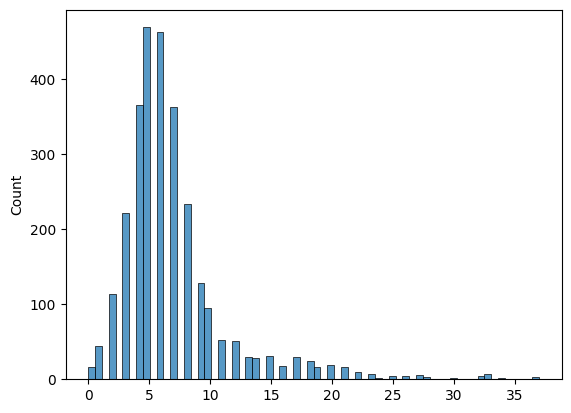

In [30]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

In [31]:
#for i in df.columns:
#  plt.figure()
#  sns.histplot(df[i])

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [32]:
df = df.drop(df[df['bmi']>80].index)

In [33]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

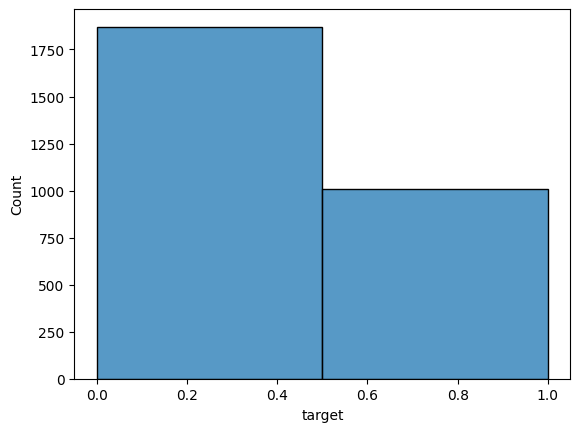

In [34]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [35]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

In [36]:
column_names = df.columns

Поделим датасет на тренировочную, валидационную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

In [37]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df))
df.columns = column_names

In [38]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_train = df.drop(df_test.index)

In [39]:
x_train = df_train.drop(columns=['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_cr', 'цинк_zn',
        'профессия_работники_преимущественно_умственного_труда',
        'профессия_работники_занятые_легким_физическим_трудом',
        'спорт_легкий_спорт', 'спорт_не_занимаюсь','target'])
y_train = df_train['target']

In [40]:
x_test = df_test.drop(columns=['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_cr', 'цинк_zn',
        'профессия_работники_преимущественно_умственного_труда',
        'профессия_работники_занятые_легким_физическим_трудом',
        'спорт_легкий_спорт', 'спорт_не_занимаюсь','target'])
y_test = df_test['target']

In [41]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [42]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость'}

In [43]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость
0,-0.016934
1,-0.016934
2,-0.016934
3,-1.161526
4,0.592303
...,...
2445,-0.891602
2446,0.531894
2447,3.179896
2448,2.229602


Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. RandomForest

In [44]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [45]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 11:22:08,013] A new study created in memory with name: no-name-5dfe624d-e4c0-4460-afc0-eb38c25475c5
[I 2024-11-11 11:22:10,231] Trial 0 finished with value: 0.4070175438596491 and parameters: {'max_depth': 6, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4070175438596491.
[I 2024-11-11 11:22:11,692] Trial 1 finished with value: 0.4070175438596491 and parameters: {'max_depth': 5, 'n_estimators': 700, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4070175438596491.
[I 2024-11-11 11:22:12,208] Trial 2 finished with value: 0.4275862068965517 and parameters: {'max_depth': 9, 'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.4275862068965517.
[I 2024-11-11 11:22:13,747] Trial 3 finished with value: 0.4014084507042254 and parameters: {'max_depth': 6, 'n_estimators': 700, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 2 with value: 

In [46]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 4}
Best ROC-AUC score: 0.5016077170418006


In [47]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=200)

Метрики, получаемые из кросс-валидации

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.44885087, 0.44225359, 0.42979312, 0.42580104, 0.42268443]),
 'score_time': array([0.04506779, 0.03893614, 0.0408237 , 0.03958273, 0.04244065]),
 'test_accuracy': array([0.82244898, 0.81632653, 0.76326531, 0.77959184, 0.72857143]),
 'test_precision_macro': array([0.84552977, 0.79749609, 0.7324597 , 0.74881119, 0.70234883]),
 'test_recall_macro': array([0.74438998, 0.77090577, 0.74470349, 0.75351992, 0.72229189]),
 'test_f1_macro': array([0.7682283 , 0.78134111, 0.73731884, 0.75101626, 0.70698392]),
 'test_roc_auc': array([0.89137168, 0.88871155, 0.82635049, 0.84353683, 0.79691805])}

In [49]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [50]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [51]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [52]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.93      0.71       216
         1.0       0.81      0.32      0.46       216

    accuracy                           0.62       432
   macro avg       0.70      0.62      0.59       432
weighted avg       0.70      0.62      0.59       432

F2-score:  0.3684210526315789


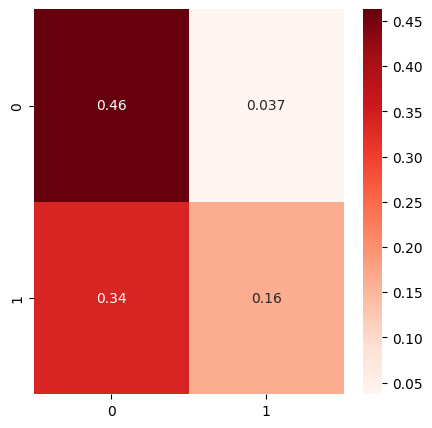

In [53]:
report(y_test, rfc_best.predict(x_test))

### 2. XGBRFClassifier

In [54]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [55]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 11:22:52,349] A new study created in memory with name: no-name-9e7cef16-004d-4f09-8ddb-cfbde7029260
[I 2024-11-11 11:22:52,505] Trial 0 finished with value: 0.48504983388704326 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 0 with value: 0.48504983388704326.


[11:22:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:22:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:54,586] Trial 1 finished with value: 0.4920127795527156 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 1 with value: 0.4920127795527156.


[11:22:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:55,330] Trial 2 finished with value: 0.4275862068965517 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 1 with value: 0.4920127795527156.


[11:22:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:55,690] Trial 3 finished with value: 0.34558823529411764 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 1 with value: 0.4920127795527156.


[11:22:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:57,077] Trial 4 finished with value: 0.4178082191780822 and parameters: {'max_depth': 8, 'n_estimators': 1000}. Best is trial 1 with value: 0.4920127795527156.


[11:22:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:57,454] Trial 5 finished with value: 0.4329896907216495 and parameters: {'max_depth': 6, 'n_estimators': 400}. Best is trial 1 with value: 0.4920127795527156.


[11:22:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:58,394] Trial 6 finished with value: 0.4166666666666667 and parameters: {'max_depth': 6, 'n_estimators': 1000}. Best is trial 1 with value: 0.4920127795527156.


[11:22:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:22:59,195] Trial 7 finished with value: 0.47249190938511326 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 1 with value: 0.4920127795527156.


[11:22:59] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:00,666] Trial 8 finished with value: 0.47249190938511326 and parameters: {'max_depth': 9, 'n_estimators': 900}. Best is trial 1 with value: 0.4920127795527156.


[11:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:00,855] Trial 9 finished with value: 0.34558823529411764 and parameters: {'max_depth': 4, 'n_estimators': 300}. Best is trial 1 with value: 0.4920127795527156.


[11:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:02,209] Trial 10 finished with value: 0.4904458598726114 and parameters: {'max_depth': 10, 'n_estimators': 700}. Best is trial 1 with value: 0.4920127795527156.


[11:23:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:03,577] Trial 11 finished with value: 0.4904458598726114 and parameters: {'max_depth': 10, 'n_estimators': 700}. Best is trial 1 with value: 0.4920127795527156.


[11:23:03] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:05,123] Trial 12 finished with value: 0.4904458598726114 and parameters: {'max_depth': 10, 'n_estimators': 800}. Best is trial 1 with value: 0.4920127795527156.


[11:23:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:06,119] Trial 13 finished with value: 0.4774193548387097 and parameters: {'max_depth': 9, 'n_estimators': 600}. Best is trial 1 with value: 0.4920127795527156.


[11:23:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:07,238] Trial 14 finished with value: 0.4178082191780822 and parameters: {'max_depth': 8, 'n_estimators': 800}. Best is trial 1 with value: 0.4920127795527156.


[11:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:08,624] Trial 15 finished with value: 0.4178082191780822 and parameters: {'max_depth': 8, 'n_estimators': 1000}. Best is trial 1 with value: 0.4920127795527156.


[11:23:08] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:09,593] Trial 16 finished with value: 0.4952380952380952 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:10,069] Trial 17 finished with value: 0.4137931034482759 and parameters: {'max_depth': 7, 'n_estimators': 400}. Best is trial 16 with value: 0.4952380952380952.
[I 2024-11-11 11:23:10,201] Trial 18 finished with value: 0.41924398625429554 and parameters: {'max_depth': 7, 'n_estimators': 100}. Best is trial 16 with value: 0.4952380952380952.


[11:23:10] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:10] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:11,170] Trial 19 finished with value: 0.4952380952380952 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:11] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:11,996] Trial 20 finished with value: 0.4774193548387097 and parameters: {'max_depth': 9, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:12,967] Trial 21 finished with value: 0.4952380952380952 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:13,956] Trial 22 finished with value: 0.4952380952380952 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:14,470] Trial 23 finished with value: 0.47249190938511326 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 16 with value: 0.4952380952380952.


[11:23:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:14,910] Trial 24 finished with value: 0.41237113402061853 and parameters: {'max_depth': 8, 'n_estimators': 300}. Best is trial 16 with value: 0.4952380952380952.


[11:23:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:15,885] Trial 25 finished with value: 0.4952380952380952 and parameters: {'max_depth': 10, 'n_estimators': 500}. Best is trial 16 with value: 0.4952380952380952.


[11:23:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:16,882] Trial 26 finished with value: 0.4774193548387097 and parameters: {'max_depth': 9, 'n_estimators': 600}. Best is trial 16 with value: 0.4952380952380952.
[I 2024-11-11 11:23:17,048] Trial 27 finished with value: 0.42214532871972316 and parameters: {'max_depth': 5, 'n_estimators': 200}. Best is trial 16 with value: 0.4952380952380952.


[11:23:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:17] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:18,393] Trial 28 finished with value: 0.4904458598726114 and parameters: {'max_depth': 10, 'n_estimators': 700}. Best is trial 16 with value: 0.4952380952380952.


[11:23:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:23:18,594] Trial 29 finished with value: 0.48504983388704326 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 16 with value: 0.4952380952380952.


In [56]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 500}
Best f1 score: 0.4952380952380952


In [57]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train, y_train)

[11:23:18] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [58]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_rfc_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[11:23:19] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:20] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:22] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:23:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



{'fit_time': array([0.83494949, 0.8449254 , 0.80725479, 0.85021663, 0.80816245]),
 'score_time': array([0.01458764, 0.01463699, 0.01459932, 0.01453185, 0.0142889 ]),
 'test_accuracy': array([0.81020408, 0.81836735, 0.76122449, 0.77346939, 0.72244898]),
 'test_precision_macro': array([0.82884531, 0.80054084, 0.73004126, 0.74246324, 0.69642025]),
 'test_recall_macro': array([0.72879021, 0.77241635, 0.74155884, 0.75062228, 0.71612609]),
 'test_f1_macro': array([0.75095503, 0.78334849, 0.73467546, 0.74605353, 0.70073111]),
 'test_roc_auc': array([0.87640844, 0.8795721 , 0.82193277, 0.83604097, 0.78951719])}

In [59]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.59      0.90      0.71       216
         1.0       0.79      0.36      0.50       216

    accuracy                           0.63       432
   macro avg       0.69      0.63      0.60       432
weighted avg       0.69      0.63      0.60       432

F2-score:  0.40498442367601245


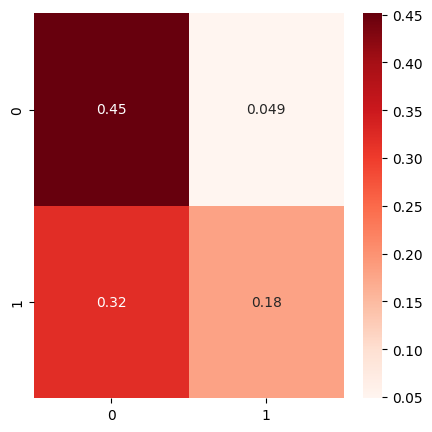

In [60]:
report(y_test, xgb_rfc_best.predict(x_test))

## Бустинги

### Catboost

In [61]:
import catboost

In [62]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [63]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 11:23:24,088] A new study created in memory with name: no-name-9b05312f-5262-4178-a085-8f43120d6aea
[I 2024-11-11 11:23:24,833] Trial 0 finished with value: 0.19087136929460582 and parameters: {'learning_rate': 0.009314394061888406, 'depth': 3, 'subsample': 0.4559309046719248, 'colsample_bylevel': 0.6704980592600035, 'min_data_in_leaf': 12, 'random_strength': 1.999346496223177}. Best is trial 0 with value: 0.19087136929460582.
[I 2024-11-11 11:23:25,450] Trial 1 finished with value: 0.38571428571428573 and parameters: {'learning_rate': 0.07881828822329377, 'depth': 5, 'subsample': 0.820384162285668, 'colsample_bylevel': 0.45969803205799303, 'min_data_in_leaf': 7, 'random_strength': 1.4443079412877384}. Best is trial 1 with value: 0.38571428571428573.
[I 2024-11-11 11:23:26,020] Trial 2 finished with value: 0.12121212121212122 and parameters: {'learning_rate': 0.011697170689545969, 'depth': 4, 'subsample': 0.08938547602931324, 'colsample_bylevel': 0.31401657334855515, 'min

In [64]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.019690634946944723, 'depth': 7, 'subsample': 0.778612842172843, 'colsample_bylevel': 0.8757806595335581, 'min_data_in_leaf': 78, 'random_strength': 0.8637896527544826}
Best f1 score: 0.44444444444444453


In [65]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train, y_train)

0:	learn: 0.6834550	total: 1.63ms	remaining: 1.62s
1:	learn: 0.6738818	total: 2.51ms	remaining: 1.25s
2:	learn: 0.6652518	total: 3.21ms	remaining: 1.07s
3:	learn: 0.6630946	total: 3.77ms	remaining: 938ms
4:	learn: 0.6610267	total: 4.31ms	remaining: 857ms
5:	learn: 0.6509086	total: 5.31ms	remaining: 880ms
6:	learn: 0.6409399	total: 6.83ms	remaining: 969ms
7:	learn: 0.6333556	total: 7.78ms	remaining: 965ms
8:	learn: 0.6316832	total: 8.34ms	remaining: 918ms
9:	learn: 0.6300774	total: 8.87ms	remaining: 878ms
10:	learn: 0.6199565	total: 10.3ms	remaining: 927ms
11:	learn: 0.6126270	total: 11.8ms	remaining: 972ms
12:	learn: 0.6063508	total: 12.6ms	remaining: 955ms
13:	learn: 0.5967489	total: 13.7ms	remaining: 967ms
14:	learn: 0.5904133	total: 14.5ms	remaining: 950ms
15:	learn: 0.5839939	total: 15.9ms	remaining: 981ms
16:	learn: 0.5782866	total: 16.6ms	remaining: 963ms
17:	learn: 0.5702568	total: 18.2ms	remaining: 991ms
18:	learn: 0.5648709	total: 19.7ms	remaining: 1.02s
19:	learn: 0.5578246	t

In [66]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6822576	total: 1.49ms	remaining: 1.49s
1:	learn: 0.6704427	total: 2.76ms	remaining: 1.38s
2:	learn: 0.6608470	total: 3.54ms	remaining: 1.18s
3:	learn: 0.6517952	total: 4.48ms	remaining: 1.11s
4:	learn: 0.6423233	total: 5.38ms	remaining: 1.07s
5:	learn: 0.6342888	total: 6.17ms	remaining: 1.02s
6:	learn: 0.6255509	total: 7.55ms	remaining: 1.07s
7:	learn: 0.6176142	total: 8.99ms	remaining: 1.11s
8:	learn: 0.6101366	total: 10.4ms	remaining: 1.14s
9:	learn: 0.6035308	total: 11.3ms	remaining: 1.11s
10:	learn: 0.5975015	total: 11.9ms	remaining: 1.07s
11:	learn: 0.5907851	total: 12.6ms	remaining: 1.04s
12:	learn: 0.5844680	total: 13.7ms	remaining: 1.04s
13:	learn: 0.5790700	total: 14.4ms	remaining: 1.02s
14:	learn: 0.5735556	total: 15.9ms	remaining: 1.04s
15:	learn: 0.5674746	total: 17.2ms	remaining: 1.05s
16:	learn: 0.5624129	total: 17.8ms	remaining: 1.03s
17:	learn: 0.5582949	total: 18.4ms	remaining: 1s
18:	learn: 0.5534566	total: 19.7ms	remaining: 1.02s
19:	learn: 0.5525733	tota

{'fit_time': array([1.02330542, 1.00890994, 1.01557302, 0.99393749, 0.99372363]),
 'score_time': array([0.00848579, 0.00827646, 0.00835824, 0.00801659, 0.00821853]),
 'test_accuracy': array([0.82244898, 0.84693878, 0.7877551 , 0.7877551 , 0.75306122]),
 'test_precision_macro': array([0.84552977, 0.83080443, 0.75929153, 0.75815222, 0.72265235]),
 'test_recall_macro': array([0.74438998, 0.81317335, 0.77426894, 0.76609854, 0.73715062]),
 'test_f1_macro': array([0.7682283 , 0.82084619, 0.76515696, 0.76170881, 0.72790146]),
 'test_roc_auc': array([0.90531836, 0.89821201, 0.84381235, 0.85469988, 0.8203367 ])}

In [67]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.57      0.95      0.71       216
         1.0       0.85      0.28      0.42       216

    accuracy                           0.61       432
   macro avg       0.71      0.61      0.56       432
weighted avg       0.71      0.61      0.56       432

F2-score:  0.32085561497326204


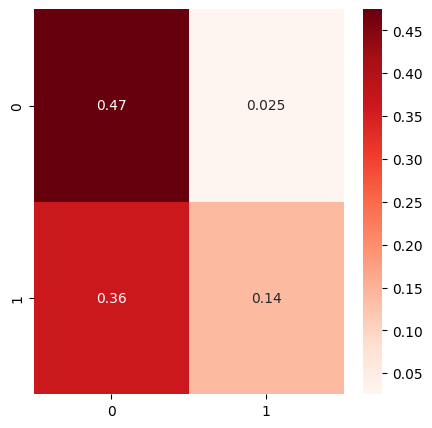

In [68]:
report(y_test, cb_best.predict(x_test))

### XGBoost

In [69]:
model = XGBClassifier()

In [70]:
model.fit(
    x_train,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [71]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [72]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 11:23:57,115] A new study created in memory with name: no-name-003e4679-3069-47a9-b8a2-1cc992c169a1


[11:23:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:23:58,676] Trial 0 finished with value: 0.38434163701067614 and parameters: {'learning_rate': 0.0034742052488038687, 'max_depth': 174, 'n_estimators': 900, 'subsample': 0.3927400269726492, 'colsample_bylevel': 0.2603650364053394, 'gamma': 2.72234976818829}. Best is trial 0 with value: 0.38434163701067614.


[11:23:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:23:59,311] Trial 1 finished with value: 0.2889733840304182 and parameters: {'learning_rate': 0.00490671750337254, 'max_depth': 173, 'n_estimators': 800, 'subsample': 0.08310745887953933, 'colsample_bylevel': 0.7251888306038377, 'gamma': 1.9437101146295914}. Best is trial 0 with value: 0.38434163701067614.


[11:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:23:59,997] Trial 2 finished with value: 0.4645161290322581 and parameters: {'learning_rate': 0.047263211349951345, 'max_depth': 499, 'n_estimators': 600, 'subsample': 0.2120166330243795, 'colsample_bylevel': 0.4398009630438372, 'gamma': 0.6859864996688968}. Best is trial 2 with value: 0.4645161290322581.


[11:23:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:03,266] Trial 3 finished with value: 0.5078369905956112 and parameters: {'learning_rate': 0.04217390257219025, 'max_depth': 302, 'n_estimators': 900, 'subsample': 0.8028151417427436, 'colsample_bylevel': 0.32169682947757205, 'gamma': 2.528313133558399}. Best is trial 3 with value: 0.5078369905956112.


[11:24:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:04,910] Trial 4 finished with value: 0.4758842443729904 and parameters: {'learning_rate': 0.009629706268389287, 'max_depth': 219, 'n_estimators': 900, 'subsample': 0.43077010113662995, 'colsample_bylevel': 0.6007834526429937, 'gamma': 0.8153771042569316}. Best is trial 3 with value: 0.5078369905956112.


[11:24:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:06,205] Trial 5 finished with value: 0.4560260586319218 and parameters: {'learning_rate': 0.011800877745599963, 'max_depth': 382, 'n_estimators': 800, 'subsample': 0.3613713415324054, 'colsample_bylevel': 0.30518539922959476, 'gamma': 1.566788490060804}. Best is trial 3 with value: 0.5078369905956112.


[11:24:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:07,393] Trial 6 finished with value: 0.48580441640378547 and parameters: {'learning_rate': 0.018564697559498234, 'max_depth': 161, 'n_estimators': 600, 'subsample': 0.46646806746408026, 'colsample_bylevel': 0.21703693815697483, 'gamma': 1.6679029109239707}. Best is trial 3 with value: 0.5078369905956112.


[11:24:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:09,355] Trial 7 finished with value: 0.4952978056426332 and parameters: {'learning_rate': 0.013887225505415044, 'max_depth': 264, 'n_estimators': 900, 'subsample': 0.5461755863369779, 'colsample_bylevel': 0.4633713773514212, 'gamma': 0.8237471044533486}. Best is trial 3 with value: 0.5078369905956112.


[11:24:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:09,695] Trial 8 finished with value: 0.3799283154121864 and parameters: {'learning_rate': 0.006984647370819654, 'max_depth': 105, 'n_estimators': 300, 'subsample': 0.23595689948397597, 'colsample_bylevel': 0.5893974205327291, 'gamma': 2.437877106043555}. Best is trial 3 with value: 0.5078369905956112.


[11:24:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:09,788] Trial 9 finished with value: 0.3584229390681003 and parameters: {'learning_rate': 0.019922425607008687, 'max_depth': 123, 'n_estimators': 100, 'subsample': 0.12565896107914226, 'colsample_bylevel': 0.055499423410221835, 'gamma': 0.10061705719521881}. Best is trial 3 with value: 0.5078369905956112.


[11:24:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:11,599] Trial 10 finished with value: 0.3929824561403508 and parameters: {'learning_rate': 0.09687813263374147, 'max_depth': 334, 'n_estimators': 400, 'subsample': 0.8734201497274368, 'colsample_bylevel': 0.9570442567917979, 'gamma': 2.998455852229056}. Best is trial 3 with value: 0.5078369905956112.


[11:24:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:14,317] Trial 11 finished with value: 0.5061728395061729 and parameters: {'learning_rate': 0.03795195803150967, 'max_depth': 264, 'n_estimators': 1000, 'subsample': 0.7253060503267291, 'colsample_bylevel': 0.43079381740138134, 'gamma': 0.8568641364617439}. Best is trial 3 with value: 0.5078369905956112.


[11:24:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:16,618] Trial 12 finished with value: 0.42214532871972316 and parameters: {'learning_rate': 0.0013129110205047166, 'max_depth': 305, 'n_estimators': 1000, 'subsample': 0.8034855138173491, 'colsample_bylevel': 0.3666248186842481, 'gamma': 2.2131643723098593}. Best is trial 3 with value: 0.5078369905956112.


[11:24:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:19,263] Trial 13 finished with value: 0.4952978056426332 and parameters: {'learning_rate': 0.04433976308644746, 'max_depth': 388, 'n_estimators': 1000, 'subsample': 0.6942674383308056, 'colsample_bylevel': 0.1432857434970521, 'gamma': 1.2140790923636176}. Best is trial 3 with value: 0.5078369905956112.


[11:24:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:25,036] Trial 14 finished with value: 0.5137614678899083 and parameters: {'learning_rate': 0.03745436372519975, 'max_depth': 247, 'n_estimators': 700, 'subsample': 0.99280356987434, 'colsample_bylevel': 0.7514761218054221, 'gamma': 0.14744169305941246}. Best is trial 14 with value: 0.5137614678899083.


[11:24:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:29,669] Trial 15 finished with value: 0.5182926829268293 and parameters: {'learning_rate': 0.0966485408672213, 'max_depth': 375, 'n_estimators': 500, 'subsample': 0.9992282944913599, 'colsample_bylevel': 0.786683161872645, 'gamma': 0.11437630561810908}. Best is trial 15 with value: 0.5182926829268293.


[11:24:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:33,919] Trial 16 finished with value: 0.5137614678899083 and parameters: {'learning_rate': 0.09858511782317841, 'max_depth': 464, 'n_estimators': 500, 'subsample': 0.9954407949828956, 'colsample_bylevel': 0.8555411761058256, 'gamma': 0.11136305564512562}. Best is trial 15 with value: 0.5182926829268293.


[11:24:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:36,933] Trial 17 finished with value: 0.5015479876160991 and parameters: {'learning_rate': 0.07093857376116292, 'max_depth': 370, 'n_estimators': 700, 'subsample': 0.9414718158396048, 'colsample_bylevel': 0.7541537986634741, 'gamma': 0.434747900730712}. Best is trial 15 with value: 0.5182926829268293.


[11:24:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:37,684] Trial 18 finished with value: 0.5046728971962617 and parameters: {'learning_rate': 0.027371255849163143, 'max_depth': 415, 'n_estimators': 300, 'subsample': 0.6114852304685823, 'colsample_bylevel': 0.7242256673781395, 'gamma': 1.1533637964840304}. Best is trial 15 with value: 0.5182926829268293.


[11:24:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:41,728] Trial 19 finished with value: 0.5167173252279635 and parameters: {'learning_rate': 0.0646694183521846, 'max_depth': 239, 'n_estimators': 400, 'subsample': 0.9990045771363731, 'colsample_bylevel': 0.9782791650193021, 'gamma': 0.4000865193298064}. Best is trial 15 with value: 0.5182926829268293.


[11:24:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:42,079] Trial 20 finished with value: 0.4797507788161994 and parameters: {'learning_rate': 0.06534988994398597, 'max_depth': 344, 'n_estimators': 100, 'subsample': 0.865622682001113, 'colsample_bylevel': 0.9575619543901257, 'gamma': 0.4539775550654852}. Best is trial 15 with value: 0.5182926829268293.


[11:24:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:46,593] Trial 21 finished with value: 0.5185185185185185 and parameters: {'learning_rate': 0.06659574675692835, 'max_depth': 238, 'n_estimators': 500, 'subsample': 0.9916384141633428, 'colsample_bylevel': 0.8413687923341102, 'gamma': 0.42431853115079626}. Best is trial 21 with value: 0.5185185185185185.


[11:24:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:48,091] Trial 22 finished with value: 0.5 and parameters: {'learning_rate': 0.06049624514733698, 'max_depth': 224, 'n_estimators': 400, 'subsample': 0.9030830957389627, 'colsample_bylevel': 0.8557405260863785, 'gamma': 0.44042672685994044}. Best is trial 21 with value: 0.5185185185185185.


[11:24:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:49,656] Trial 23 finished with value: 0.5015479876160991 and parameters: {'learning_rate': 0.02676517570357715, 'max_depth': 434, 'n_estimators': 500, 'subsample': 0.7765304650306895, 'colsample_bylevel': 0.8630896113034079, 'gamma': 1.2072507917944932}. Best is trial 21 with value: 0.5185185185185185.


[11:24:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:50,888] Trial 24 finished with value: 0.5 and parameters: {'learning_rate': 0.09775133145530132, 'max_depth': 210, 'n_estimators': 300, 'subsample': 0.9229951211969816, 'colsample_bylevel': 0.9944095569611151, 'gamma': 0.5422445445948972}. Best is trial 21 with value: 0.5185185185185185.


[11:24:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:54,019] Trial 25 finished with value: 0.5031055900621119 and parameters: {'learning_rate': 0.06923273113564661, 'max_depth': 284, 'n_estimators': 400, 'subsample': 0.9872438268139585, 'colsample_bylevel': 0.6319762663125943, 'gamma': 0.2960567176143427}. Best is trial 21 with value: 0.5185185185185185.


[11:24:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:54,395] Trial 26 finished with value: 0.4620462046204621 and parameters: {'learning_rate': 0.0018114207831958827, 'max_depth': 331, 'n_estimators': 200, 'subsample': 0.6636402761030391, 'colsample_bylevel': 0.9091624151749259, 'gamma': 1.020150528044162}. Best is trial 21 with value: 0.5185185185185185.


[11:24:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:56,062] Trial 27 finished with value: 0.49535603715170273 and parameters: {'learning_rate': 0.02709685379365113, 'max_depth': 201, 'n_estimators': 500, 'subsample': 0.8409423537090667, 'colsample_bylevel': 0.8164956329891075, 'gamma': 0.6156679987174659}. Best is trial 21 with value: 0.5185185185185185.


[11:24:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:58,496] Trial 28 finished with value: 0.5137614678899083 and parameters: {'learning_rate': 0.060748455711492566, 'max_depth': 242, 'n_estimators': 600, 'subsample': 0.937524447682473, 'colsample_bylevel': 0.6629469447235086, 'gamma': 0.28311182169408133}. Best is trial 21 with value: 0.5185185185185185.


[11:24:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:24:59,438] Trial 29 finished with value: 0.49517684887459806 and parameters: {'learning_rate': 0.004185386714155581, 'max_depth': 136, 'n_estimators': 400, 'subsample': 0.7497072214784879, 'colsample_bylevel': 0.7882679188946199, 'gamma': 1.3846300833974257}. Best is trial 21 with value: 0.5185185185185185.


In [73]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.06659574675692835, 'max_depth': 238, 'n_estimators': 500, 'subsample': 0.9916384141633428, 'colsample_bylevel': 0.8413687923341102, 'gamma': 0.42431853115079626}
Best f1 score: 0.5185185185185185


In [74]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train, y_train)

[11:24:59] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8413687923341102, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.42431853115079626, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06659574675692835, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=238, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [75]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

[11:25:04] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:25:07] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:25:10] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:25:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:25:17] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([3.28273439, 3.39865685, 3.07046914, 3.12098026, 3.04264402]),
 'score_time': array([0.01962972, 0.02070308, 0.01947236, 0.01908898, 0.01940155]),
 'test_accuracy': array([0.80408163, 0.79591837, 0.74285714, 0.75714286, 0.71020408]),
 'test_precision_macro': array([0.80696887, 0.77064502, 0.70984127, 0.7248062 , 0.68372792]),
 'test_recall_macro': array([0.72916073, 0.75089779, 0.71979327, 0.73363545, 0.70216041]),
 'test_f1_macro': array([0.74871795, 0.75890098, 0.71385403, 0.72856218, 0.68752807]),
 'test_roc_auc': array([0.8734823 , 0.87228524, 0.80750157, 0.82905812, 0.77572251])}

In [76]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.59      0.89      0.71       216
         1.0       0.78      0.39      0.52       216

    accuracy                           0.64       432
   macro avg       0.69      0.64      0.61       432
weighted avg       0.69      0.64      0.61       432

F2-score:  0.4320987654320988


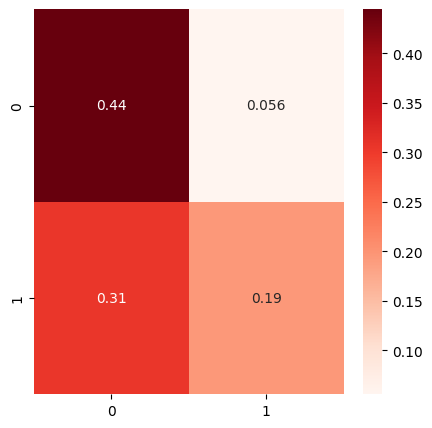

In [77]:
report(y_test, xgb_best.predict(x_test))

### LightGBM

In [78]:
model = LGBMClassifier()

In [79]:
model.fit(
    x_train,
    y_train,
    )

LGBMClassifier()

In [80]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return f1_score(y_test, predictions)

In [81]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 11:25:20,568] A new study created in memory with name: no-name-d4855b39-5954-4dc2-baa7-2aea76cc5912


[11:25:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:21,684] Trial 0 finished with value: 0.41114982578397213 and parameters: {'learning_rate': 0.0014474872273218646, 'max_depth': 127, 'n_estimators': 800, 'subsample': 0.38506545247882656, 'colsample_bylevel': 0.30166634446286505, 'gamma': 1.831914601295576}. Best is trial 0 with value: 0.41114982578397213.


[11:25:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:22,907] Trial 1 finished with value: 0.4888888888888888 and parameters: {'learning_rate': 0.03347771595848974, 'max_depth': 430, 'n_estimators': 800, 'subsample': 0.3382362822722395, 'colsample_bylevel': 0.2780260298649338, 'gamma': 0.5021010638000208}. Best is trial 1 with value: 0.4888888888888888.


[11:25:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:23,272] Trial 2 finished with value: 0.4554455445544554 and parameters: {'learning_rate': 0.003144585939418019, 'max_depth': 312, 'n_estimators': 200, 'subsample': 0.637962730141841, 'colsample_bylevel': 0.9457232540698569, 'gamma': 1.1098130555374899}. Best is trial 1 with value: 0.4888888888888888.


[11:25:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:24,140] Trial 3 finished with value: 0.47770700636942676 and parameters: {'learning_rate': 0.06081086649535925, 'max_depth': 383, 'n_estimators': 400, 'subsample': 0.5161520245292075, 'colsample_bylevel': 0.45636015041987404, 'gamma': 1.6961366687846977}. Best is trial 1 with value: 0.4888888888888888.


[11:25:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:25,306] Trial 4 finished with value: 0.4887459807073955 and parameters: {'learning_rate': 0.0017406555585651544, 'max_depth': 471, 'n_estimators': 500, 'subsample': 0.9344730936521045, 'colsample_bylevel': 0.78572429042431, 'gamma': 1.8740850320534441}. Best is trial 1 with value: 0.4888888888888888.


[11:25:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:25,388] Trial 5 finished with value: 0.21224489795918364 and parameters: {'learning_rate': 0.012824285446308701, 'max_depth': 118, 'n_estimators': 100, 'subsample': 0.10511729703223205, 'colsample_bylevel': 0.5501268830614056, 'gamma': 1.910060844425866}. Best is trial 1 with value: 0.4888888888888888.


[11:25:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:27,052] Trial 6 finished with value: 0.4474576271186441 and parameters: {'learning_rate': 0.0018193652643973882, 'max_depth': 200, 'n_estimators': 1000, 'subsample': 0.46044981410546854, 'colsample_bylevel': 0.9734913741661717, 'gamma': 1.7396572471776648}. Best is trial 1 with value: 0.4888888888888888.


[11:25:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:27,184] Trial 7 finished with value: 0.33948339483394835 and parameters: {'learning_rate': 0.006133124277737991, 'max_depth': 494, 'n_estimators': 100, 'subsample': 0.32792826714554285, 'colsample_bylevel': 0.8371057186661234, 'gamma': 2.5816312156799546}. Best is trial 1 with value: 0.4888888888888888.


[11:25:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:29,200] Trial 8 finished with value: 0.4329896907216495 and parameters: {'learning_rate': 0.00417619576316659, 'max_depth': 152, 'n_estimators': 900, 'subsample': 0.6044106117652841, 'colsample_bylevel': 0.586722779081364, 'gamma': 2.417429474171097}. Best is trial 1 with value: 0.4888888888888888.


[11:25:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:29,412] Trial 9 finished with value: 0.4166666666666667 and parameters: {'learning_rate': 0.011614392134812301, 'max_depth': 241, 'n_estimators': 100, 'subsample': 0.6815227674355687, 'colsample_bylevel': 0.1427303081155225, 'gamma': 2.5515259483706054}. Best is trial 1 with value: 0.4888888888888888.


[11:25:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:29,952] Trial 10 finished with value: 0.4530744336569579 and parameters: {'learning_rate': 0.052903541336094886, 'max_depth': 389, 'n_estimators': 800, 'subsample': 0.07907085909090528, 'colsample_bylevel': 0.206168294942283, 'gamma': 0.10783004760069437}. Best is trial 1 with value: 0.4888888888888888.


[11:25:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:33,210] Trial 11 finished with value: 0.49374999999999997 and parameters: {'learning_rate': 0.025742879559910677, 'max_depth': 499, 'n_estimators': 600, 'subsample': 0.958189000202148, 'colsample_bylevel': 0.6795704386713697, 'gamma': 0.878711491506056}. Best is trial 11 with value: 0.49374999999999997.


[11:25:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:36,979] Trial 12 finished with value: 0.5167173252279635 and parameters: {'learning_rate': 0.02834279727875059, 'max_depth': 423, 'n_estimators': 700, 'subsample': 0.9571789523819993, 'colsample_bylevel': 0.36710100404567486, 'gamma': 0.6409097105381998}. Best is trial 12 with value: 0.5167173252279635.


[11:25:37] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:39,975] Trial 13 finished with value: 0.490566037735849 and parameters: {'learning_rate': 0.022935834761351484, 'max_depth': 334, 'n_estimators': 600, 'subsample': 0.9465757578005011, 'colsample_bylevel': 0.7091182983397797, 'gamma': 0.9962133334314988}. Best is trial 12 with value: 0.5167173252279635.


[11:25:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:41,873] Trial 14 finished with value: 0.48916408668730654 and parameters: {'learning_rate': 0.023287343616561332, 'max_depth': 437, 'n_estimators': 600, 'subsample': 0.7939339484443977, 'colsample_bylevel': 0.42148895120709073, 'gamma': 0.8776102485410979}. Best is trial 12 with value: 0.5167173252279635.


[11:25:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:43,177] Trial 15 finished with value: 0.4968944099378882 and parameters: {'learning_rate': 0.09496634553240298, 'max_depth': 500, 'n_estimators': 400, 'subsample': 0.8427482143455524, 'colsample_bylevel': 0.656966667990061, 'gamma': 0.5214703802493408}. Best is trial 12 with value: 0.5167173252279635.


[11:25:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:44,082] Trial 16 finished with value: 0.5046153846153847 and parameters: {'learning_rate': 0.09688624485670214, 'max_depth': 368, 'n_estimators': 300, 'subsample': 0.8359487992835705, 'colsample_bylevel': 0.39738562028553337, 'gamma': 0.12126495193183057}. Best is trial 12 with value: 0.5167173252279635.


[11:25:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:44,940] Trial 17 finished with value: 0.5137614678899083 and parameters: {'learning_rate': 0.0935169091119915, 'max_depth': 266, 'n_estimators': 300, 'subsample': 0.7864188249154, 'colsample_bylevel': 0.39491655760908817, 'gamma': 0.23687940154243264}. Best is trial 12 with value: 0.5167173252279635.


[11:25:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:46,941] Trial 18 finished with value: 0.5015290519877675 and parameters: {'learning_rate': 0.04847318053820483, 'max_depth': 264, 'n_estimators': 700, 'subsample': 0.7187112547231134, 'colsample_bylevel': 0.29753327018885395, 'gamma': 1.308519617265572}. Best is trial 12 with value: 0.5167173252279635.


[11:25:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:47,804] Trial 19 finished with value: 0.5015673981191222 and parameters: {'learning_rate': 0.01492336989826069, 'max_depth': 281, 'n_estimators': 300, 'subsample': 0.7854505931630913, 'colsample_bylevel': 0.07060365655851902, 'gamma': 0.5120742878500305}. Best is trial 12 with value: 0.5167173252279635.


[11:25:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:50,635] Trial 20 finished with value: 0.39999999999999997 and parameters: {'learning_rate': 0.038870321160115656, 'max_depth': 209, 'n_estimators': 500, 'subsample': 0.9924047385313494, 'colsample_bylevel': 0.4793397907388153, 'gamma': 2.9535893728761677}. Best is trial 12 with value: 0.5167173252279635.


[11:25:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:51,576] Trial 21 finished with value: 0.5046153846153847 and parameters: {'learning_rate': 0.0971404341317712, 'max_depth': 341, 'n_estimators': 300, 'subsample': 0.8672948283032568, 'colsample_bylevel': 0.39951206955016794, 'gamma': 0.11618557820013276}. Best is trial 12 with value: 0.5167173252279635.


[11:25:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:52,604] Trial 22 finished with value: 0.5 and parameters: {'learning_rate': 0.07146561316932483, 'max_depth': 372, 'n_estimators': 300, 'subsample': 0.8672997912410243, 'colsample_bylevel': 0.3720980267826159, 'gamma': 0.36492637395020716}. Best is trial 12 with value: 0.5167173252279635.


[11:25:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:53,733] Trial 23 finished with value: 0.5 and parameters: {'learning_rate': 0.07364169615090015, 'max_depth': 428, 'n_estimators': 400, 'subsample': 0.7421611771940644, 'colsample_bylevel': 0.3354492548194057, 'gamma': 0.7014980323899338}. Best is trial 12 with value: 0.5167173252279635.


[11:25:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:54,417] Trial 24 finished with value: 0.4716981132075472 and parameters: {'learning_rate': 0.03603600203009782, 'max_depth': 356, 'n_estimators': 200, 'subsample': 0.8824606117751488, 'colsample_bylevel': 0.2034767978391515, 'gamma': 0.27431208292658593}. Best is trial 12 with value: 0.5167173252279635.


[11:25:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:56,470] Trial 25 finished with value: 0.5125000000000001 and parameters: {'learning_rate': 0.007201366905707355, 'max_depth': 305, 'n_estimators': 700, 'subsample': 0.7824047023367627, 'colsample_bylevel': 0.5374374089590923, 'gamma': 1.3176688989286394}. Best is trial 12 with value: 0.5167173252279635.


[11:25:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:58,060] Trial 26 finished with value: 0.48580441640378547 and parameters: {'learning_rate': 0.007367554183365181, 'max_depth': 302, 'n_estimators': 700, 'subsample': 0.5808688671208657, 'colsample_bylevel': 0.520158387363019, 'gamma': 1.3736148702314086}. Best is trial 12 with value: 0.5167173252279635.


[11:25:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:25:59,985] Trial 27 finished with value: 0.5046728971962617 and parameters: {'learning_rate': 0.008756928965125423, 'max_depth': 235, 'n_estimators': 700, 'subsample': 0.7365676118773382, 'colsample_bylevel': 0.5929406509728828, 'gamma': 0.7282753517590853}. Best is trial 12 with value: 0.5167173252279635.


[11:26:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:26:01,001] Trial 28 finished with value: 0.4620462046204621 and parameters: {'learning_rate': 0.017189222668819844, 'max_depth': 181, 'n_estimators': 900, 'subsample': 0.17479236645791096, 'colsample_bylevel': 0.49003418051686115, 'gamma': 1.2558758975314324}. Best is trial 12 with value: 0.5167173252279635.


[11:26:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:26:02,754] Trial 29 finished with value: 0.4554455445544554 and parameters: {'learning_rate': 0.0010874893527741624, 'max_depth': 258, 'n_estimators': 900, 'subsample': 0.6655382669423043, 'colsample_bylevel': 0.24249685501106083, 'gamma': 1.5192790231306015}. Best is trial 12 with value: 0.5167173252279635.


In [82]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.02834279727875059, 'max_depth': 423, 'n_estimators': 700, 'subsample': 0.9571789523819993, 'colsample_bylevel': 0.36710100404567486, 'gamma': 0.6409097105381998}
Best f1 score: 0.5167173252279635


In [83]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.02834279727875059, max_depth=423,
               n_estimators=700, random_seed=42, subsample=0.9571789523819993)

In [84]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.35071254, 0.35606194, 0.35605073, 0.34548092, 0.35475254]),
 'score_time': array([0.01953483, 0.01922774, 0.01982069, 0.02023125, 0.02052283]),
 'test_accuracy': array([0.82244898, 0.81428571, 0.77959184, 0.78367347, 0.72244898]),
 'test_precision_macro': array([0.83928571, 0.79364295, 0.75014891, 0.75428571, 0.69729209]),
 'test_recall_macro': array([0.74765814, 0.77102928, 0.7633244 , 0.76634555, 0.71776017]),
 'test_f1_macro': array([0.77057332, 0.78018348, 0.75543478, 0.75927402, 0.70143369]),
 'test_roc_auc': array([0.88031314, 0.88674495, 0.83440689, 0.84198826, 0.80388189])}

In [85]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

         0.0       0.55      0.93      0.69       216
         1.0       0.78      0.25      0.38       216

    accuracy                           0.59       432
   macro avg       0.67      0.59      0.54       432
weighted avg       0.67      0.59      0.54       432

F2-score:  0.28938906752411575


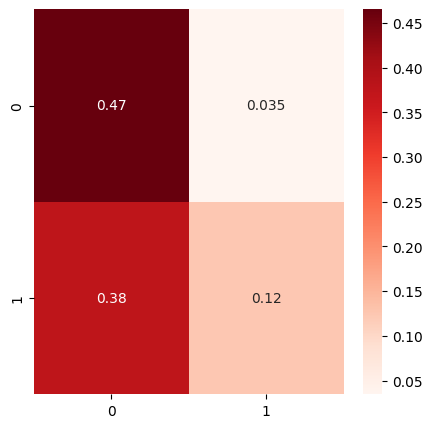

In [86]:
report(y_test, lgbm_best.predict(x_test))

# Результаты

In [87]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [88]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [89]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [90]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.78 +- 0.03 , 'AUC': 0.85 +- 0.04 ,'Precision': 0.77 +- 0.05 ,'Recall': 0.75 +- 0.02 ,'F1-score': 0.75 +- 0.03 ,'F2-score': 0.75 +- 0.02
'Accuracy': 0.78 +- 0.03 , 'AUC': 0.84 +- 0.03 ,'Precision': 0.76 +- 0.05 ,'Recall': 0.74 +- 0.02 ,'F1-score': 0.74 +- 0.03 ,'F2-score': 0.75 +- 0.02
'Accuracy': 0.76 +- 0.03 , 'AUC': 0.83 +- 0.04 ,'Precision': 0.74 +- 0.04 ,'Recall': 0.73 +- 0.02 ,'F1-score': 0.73 +- 0.03 ,'F2-score': 0.73 +- 0.02
'Accuracy': 0.78 +- 0.04 , 'AUC': 0.85 +- 0.03 ,'Precision': 0.77 +- 0.05 ,'Recall': 0.75 +- 0.02 ,'F1-score': 0.75 +- 0.03 ,'F2-score': 0.76 +- 0.02
'Accuracy': 0.8 +- 0.03 , 'AUC': 0.86 +- 0.03 ,'Precision': 0.78 +- 0.05 ,'Recall': 0.77 +- 0.03 ,'F1-score': 0.77 +- 0.03 ,'F2-score': 0.77 +- 0.03


In [91]:
for model in best_models:
  print(test_results(model, x_test, y_test))

{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.81, 'Recall': 0.32, 'F1-score': 0.46, 'F2-score': 0.37}
{'Accuracy': 0.63, 'AUC': 0.63, 'Precision': 0.79, 'Recall': 0.36, 'F1-score': 0.5, 'F2-score': 0.4}
{'Accuracy': 0.64, 'AUC': 0.64, 'Precision': 0.78, 'Recall': 0.39, 'F1-score': 0.52, 'F2-score': 0.43}
{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.78, 'Recall': 0.25, 'F1-score': 0.38, 'F2-score': 0.29}
{'Accuracy': 0.61, 'AUC': 0.61, 'Precision': 0.85, 'Recall': 0.28, 'F1-score': 0.42, 'F2-score': 0.32}
